In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
reviews = pd.read_csv('preprocessed.csv')
reviews.head()

,Text,Score
0,bought several vitality canned dog food produc...,1
1,product arrived labeled jumbo salted peanuts p...,0
2,confection around centuries light pillowy citr...,1
3,looking secret ingredient robitussin believe f...,0
4,great taffy great price wide assortment yummy ...,1


In [3]:
reviews.isna().any()

Text      True
Score    False
dtype: bool

In [4]:
reviews.dropna(axis=0,inplace=True)

In [5]:
reviews.isna().any()

Text     False
Score    False
dtype: bool

In [6]:
reviews_sample = reviews.sample(100000,random_state=42).reset_index(drop=True)
reviews_sample.head()

,Text,Score
0,tried ine beets bannans peter rabbits squash o...,1
1,love cake mix mixes well incredible amazon off...,1
2,best k cup found hands rich bold deep flavor a...,1
3,new favorite always fan salt vinegar honey dij...,1
4,product win win win healthy snack dog affordab...,1


In [7]:
reviews_sample.shape

(100000, 2)

In [8]:
reviews_train,reviews_test = train_test_split(reviews_sample,test_size=0.20, stratify = reviews_sample['Score'],
                                              random_state=33)

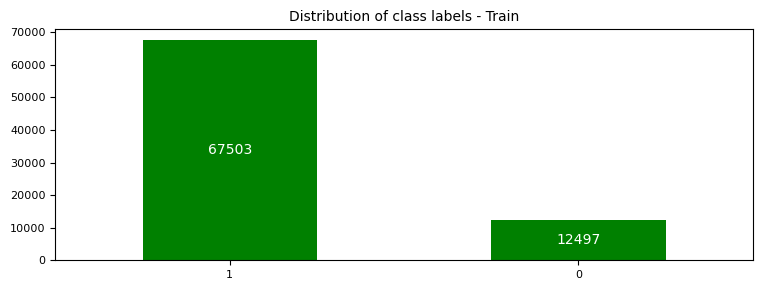

In [9]:
#plot bar graphs of train and test Scores
plt.figure(figsize=(9,3))
ax = reviews_train['Score'].value_counts().plot(kind='bar',color='green')
plt.xticks(size=8,rotation=0)
plt.yticks(size=8)

for container in ax.containers:
    ax.bar_label(container,label_type='center',color='white')
plt.title('Distribution of class labels - Train',size=10)    
plt.show()

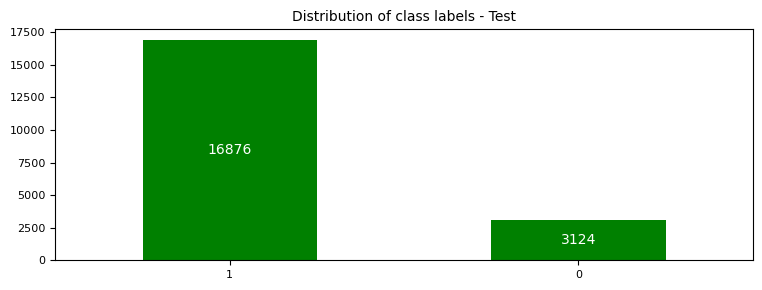

In [11]:
plt.figure(figsize=(9,3))
ax = reviews_test['Score'].value_counts().plot(kind='bar',color='green')
plt.xticks(size=8,rotation=0)
plt.yticks(size=8)

for container in ax.containers:
    ax.bar_label(container,label_type='center',color='white')
plt.title('Distribution of class labels - Test',size=10)    
plt.show()

In [12]:
X_train,y_train = np.array(reviews_train['Text']), np.array(reviews_train['Score'])
X_test,y_test   = np.array(reviews_test['Text']), np.array(reviews_test['Score'])

**Creating Tfidf Model**

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_features=768)                # Adjust max_features based on dataset
X_train_tfidf    = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf     = tfidf_vectorizer.transform(X_test).toarray()

In [14]:
# Print shapes to confirm
print(f"TF-IDF training data shape: {X_train_tfidf.shape}")
print(f"TF-IDF test data shape: {X_test_tfidf.shape}")

TF-IDF training data shape: (80000, 768)
TF-IDF test data shape: (20000, 768)


In [15]:
y_train_cat = to_categorical(y_train,2)
y_test_cat  = to_categorical(y_test,2)

In [16]:
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)

    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [26]:
input_layer    = Input(shape=(X_train_tfidf.shape[1],), name='input_layer')
Layer1         = Dense(128, activation='relu', name = 'Dense_1')(input_layer)
Layer2         = Dense(64, activation='relu', name = 'Dense_2')(Layer1)
Layer3         = Dense(32, activation='relu', name = 'Dense_3')(Layer2)
Layer4         = Dense(16, activation='relu', name = 'Dense_4')(Layer3)
Layer5         = Dense(8, activation='relu', name = 'Dense_5')(Layer4)
output         = Dense(2, activation='softmax', name = 'output_layer')(Layer5)
model          = Model(inputs = input_layer, outputs=output,name='Bert')
model.compile(optimizer = Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=[f1_score])
model.summary()

Model: "Bert"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 768)]             0         
                                                                 
 Dense_1 (Dense)             (None, 128)               98432     
                                                                 
 Dense_2 (Dense)             (None, 64)                8256      
                                                                 
 Dense_3 (Dense)             (None, 32)                2080      
                                                                 
 Dense_4 (Dense)             (None, 16)                528       
                                                                 
 Dense_5 (Dense)             (None, 8)                 136       
                                                                 
 output_layer (Dense)        (None, 2)                 18     

In [27]:
es        = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=3)
mc        = ModelCheckpoint('NLP_Tfidf.h5', monitor='val_f1_score', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', mode='max', factor=0.1, patience=2, verbose=1)
model.fit(X_train_tfidf,y_train_cat, epochs=50, batch_size=256,
          validation_data = (X_test_tfidf,y_test_cat),
          callbacks = [es, mc, reduce_lr])

Epoch 1/50
309/313 [============================>.] - ETA: 0s - loss: 0.4840 - f1_score: 0.9152
Epoch 1: val_f1_score improved from -inf to 0.91513, saving model to NLP_Tfidf.h5
313/313 [==============================] - 2s 4ms/step - loss: 0.4830 - f1_score: 0.9151 - val_loss: 0.3800 - val_f1_score: 0.9151 - lr: 1.0000e-04
Epoch 2/50
302/313 [===========================>..] - ETA: 0s - loss: 0.3252 - f1_score: 0.9151
Epoch 2: val_f1_score did not improve from 0.91513
313/313 [==============================] - 1s 3ms/step - loss: 0.3233 - f1_score: 0.9151 - val_loss: 0.2760 - val_f1_score: 0.9151 - lr: 1.0000e-04
Epoch 3/50
301/313 [===========================>..] - ETA: 0s - loss: 0.2619 - f1_score: 0.9267
Epoch 3: val_f1_score improved from 0.91513 to 0.94091, saving model to NLP_Tfidf.h5
313/313 [==============================] - 1s 3ms/step - loss: 0.2623 - f1_score: 0.9272 - val_loss: 0.2626 - val_f1_score: 0.9409 - lr: 1.0000e-04
Epoch 4/50
297/313 [===========================>..

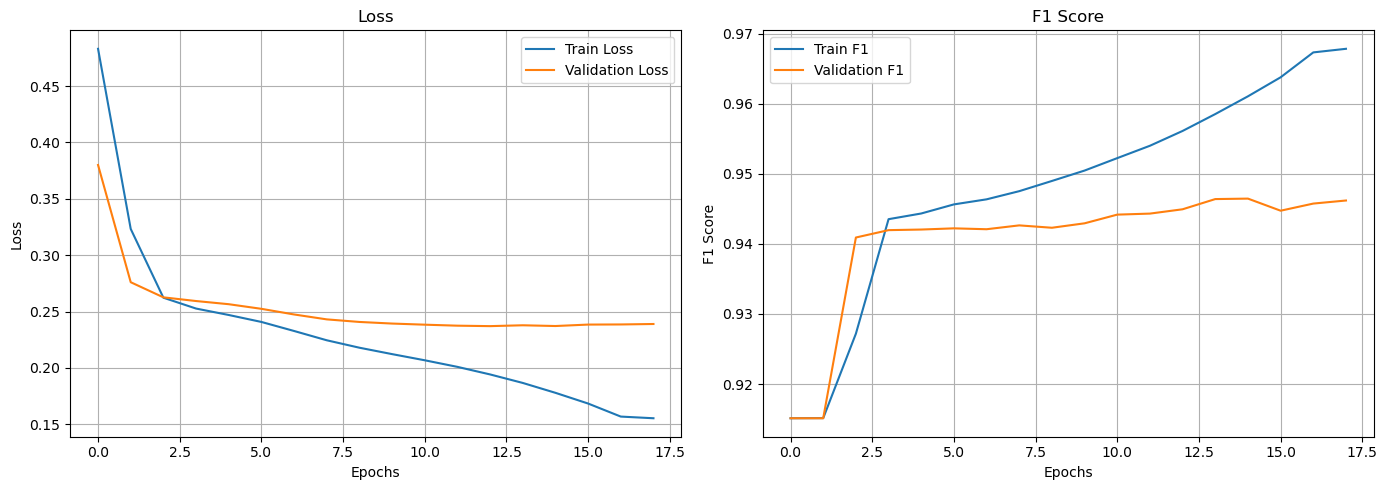

In [28]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and validation loss
axes[0].plot(model.history.history['loss'], label='Train Loss')
axes[0].plot(model.history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Plot training and validation AUC
if 'f1_score' in model.history.history:
    axes[1].plot(model.history.history['f1_score'], label='Train F1')
    axes[1].plot(model.history.history['val_f1_score'], label='Validation F1')
    axes[1].set_title('F1 Score')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1 Score')
    axes[1].legend()
    axes[1].grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()